In [1]:
import numpy as np
import baseline_model
from casadi import *
import do_mpc
import decentralized as dec
import util
import sim_drone_main
from baseline_model import baseline_drone_model
from baseline_model_mpc import baseline_drone_mpc
from baseline_model_simulator import baseline_drone_simulator
import itertools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Q = np.eye(6)
R = np.eye(3)
n_agents = 3
n_inputs = 3
n_states = 6
Qf = Q*1e3

In [4]:
Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents

In [5]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(6, 1))
u = model.set_variable(var_type='_u', var_name='u', shape=(3, 1))
print(f'Shape of x is {x.shape}')
print(f'Shape of u is {u.shape}')
#x = p_x,p_y,p_z,v_x,v_y,v_z
#u = theta, phi, tau
g = 9.81
model.set_rhs('x', vertcat(x[3], x[4], x[5], g*np.tan(u[0]), -g*np.tan(u[1]), u[2]-g))

Shape of x is (6, 1)
Shape of u is (3, 1)


In [6]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 5

x_dims = [6,6,6]

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode=200
x_baseline_init, x_baseline_f = util.paper_setup_3_quads() 
#concatenated initial and final states of all 3 agents

x_baseline1 = x_baseline_init

states_list = np.zeros((episode+1,9)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [7]:
baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[0].flatten(), Q, R, Qf,x_baseline1,x_dims)

In [8]:
model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, R, Qf, x_baseline1, x_dims) for i in range(n_agents)]

In [9]:
mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline1,x_dims, v_max, theta_max, phi_max, tau_max) for model_i in model_baseline]

/home/randy233/anaconda3/envs/Randy/lib/python3.10/site-packages/do_mpc/controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [10]:
simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]

In [11]:
dec.split_agents(x_baseline1.reshape(1,-1),x_dims)[0]

array([[0.493, 1.498, 0.999, 0.   , 0.   , 0.   ]])

In [12]:
simulator_baseline

In [13]:
split_states = dec.split_agents(x_baseline1.reshape(1,-1),x_dims)
for m in range(len(simulator_baseline)):
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

In [14]:
u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
u_dims = [3,3,3]

In [15]:
split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
split_inputs

[array([[0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.]])]

In [16]:
for m in range(len(mpc_baseline)):
    print(split_inputs[m].T.shape)

(3, 1)
(3, 1)
(3, 1)


In [17]:
u0_baseline = []
x_baseline_next = []
for m in range(len(mpc_baseline)):
    mpc_baseline[m].u0 = split_inputs[m].T
    simulator_baseline[m].u0 = split_inputs[m].T
    mpc_baseline[m].set_initial_guess()
    u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
    x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality co

In [18]:
[mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))][0]

array([[ 3.292e+03,  7.001e+00,  1.232e+03,  7.721e+02,  3.972e-01,
         5.520e+03, -2.440e+03, -5.027e+00, -9.240e+02, -5.384e+02,
        -2.141e-01, -4.124e+03, -8.132e+02, -1.676e+00, -3.080e+02,
        -1.524e+02, -1.551e-02, -1.365e+03,  3.253e+03,  6.702e+00,
         1.232e+03,  6.095e+02,  6.205e-02,  5.458e+03, -2.440e+03,
        -5.027e+00, -9.240e+02, -4.164e+02,  3.724e-02, -4.078e+03,
        -8.132e+02, -1.676e+00, -3.080e+02, -1.117e+02,  6.827e-02,
        -1.349e+03,  3.253e+03,  6.702e+00,  1.232e+03,  4.468e+02,
        -2.731e-01,  5.396e+03, -3.253e+03, -6.702e+00, -1.232e+03,
        -4.468e+02,  2.731e-01, -5.396e+03,  9.954e+00, -2.410e+03,
        -4.825e+00, -9.236e+02, -3.034e+02, -1.632e-01, -4.025e+03,
        -8.034e+02, -1.608e+00, -3.079e+02, -7.437e+01, -7.834e-04,
        -1.331e+03,  3.214e+03,  6.433e+00,  1.231e+03,  2.975e+02,
         3.134e-03,  5.325e+03, -2.410e+03, -4.825e+00, -9.236e+02,
        -1.829e+02,  7.806e-02, -3.979e+03, -8.0

In [19]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 5

x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode= 200
x_baseline_init, x_baseline_f = util.paper_setup_3_quads()

x_baseline1 = x_baseline_init #concatenated states of all agents

states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [20]:
n_agents = 3
n_states = 6
n_inputs = 3

def setup_baseline(x_baseline, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                    x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius):
    model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, \
                     R, Qf, x_baseline, x_dims) for i in range(n_agents)] 
    #a list of baseline models for each agent
    
    mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline, x_dims, v_max, theta_max, phi_max,\
                   tau_max) for model_i in model_baseline]
    #a list of baseline mpc controllers for each agent
    
    simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]
    
    #splitting the states of each agent
    split_states = dec.split_agents(x_baseline.reshape(1,-1),x_dims)

    for m in range(len(simulator_baseline)):
        
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

    u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
    split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
    
    u0_baseline = []
    x_baseline_next = []
    for m in range(len(mpc_baseline)):
        mpc_baseline[m].u0 = split_inputs[m].T
        simulator_baseline[m].u0 = split_inputs[m].T
        mpc_baseline[m].set_initial_guess()
        u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
        x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T))

    return u0_baseline, x_baseline_next, [mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))]
    #last _lam_g_num is the Lagrange multiplier

In [21]:
import concurrent.futures
import time

In [22]:
episode=10

In [23]:
states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()


In [24]:
pos_prev = np.array([x_baseline1[0], x_baseline1[1], x_baseline1[2],\
                        x_baseline1[6], x_baseline1[7], x_baseline1[8], \
                        x_baseline1[12], x_baseline1[13], x_baseline1[14]])
    
    #Initialize velcoity vectors
#     vx_prev = [0, 0, 0]
#     vy_prev = [0, 0, 0]
#     vz_prev = [0, 0, 0]
    
velocity_prev = np.zeros((n_agents*3,1))

In [26]:
time_start = time.perf_counter()
# results = []

with concurrent.futures.ProcessPoolExecutor(100) as executor:

        for k in range(episode):
            f = executor.submit(setup_baseline,x_baseline1, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                        x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius)
            """
            TODO:separate the states of each agent from f.result()
            """
            # results.append(f)

            for m in range(n_agents):
                #Get current positions of each drone:
                states_list[k+1,m*3:(m+1)*3] = f.result()[1][m][0:3].flatten() 
                #velocity components will be estimated through finite-difference approx.

            # print("Lagrange Multiplier: ", la_mul)
            # print("Length of Lagrange Multiplier: ", len(la_mul[0]))
        # ------------------------------------------------------------
               
            for j in range(n_agents):
                #position update:
                x_baseline1[(j+1-1)*3+j*3:(j+1)*3+j*3]  = states_list[k+1,j*3:(j+1)*3].reshape(-1,1) 
                #velocity update via finite-diff:
                x_baseline1[(j+1)*3+j*3:(j+2)*3+j*3]  = -(velocity_prev[j*3:(j+1)*3] - states_list[k+1,j*3:(j+1)*3].reshape(-1,1) ) / 0.1
            
        for n in range(n_agents):
            velocity_prev[n*3:(n+1)*3] = x_baseline1[(n+1)*3+n*3:(n+2)*3+n*3]
                
time_finish = time.perf_counter()
print("Total time: ", time_finish - time_start) 

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3450587e+03 4.91e-01 1.36e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [27]:
states_list

array([[5.017e-01, 1.518e+00, 9.942e-01, 2.503e+00, 1.502e+00, 1.001e+00,
        1.493e+00, 1.292e+00, 9.889e-01],
       [5.017e-01, 1.518e+00, 9.452e-01, 2.503e+00, 1.502e+00, 9.522e-01,
        1.493e+00, 1.292e+00, 9.398e-01],
       [1.003e+00, 3.036e+00, 1.841e+00, 5.005e+00, 3.005e+00, 1.855e+00,
        2.986e+00, 2.584e+00, 1.831e+00],
       [2.007e+00, 6.071e+00, 3.634e+00, 1.001e+01, 6.009e+00, 3.662e+00,
        5.972e+00, 5.168e+00, 3.612e+00],
       [4.014e+00, 1.214e+01, 7.218e+00, 2.002e+01, 1.202e+01, 7.274e+00,
        1.194e+01, 1.034e+01, 7.175e+00],
       [8.027e+00, 2.429e+01, 1.439e+01, 4.004e+01, 2.404e+01, 1.450e+01,
        2.389e+01, 2.067e+01, 1.430e+01],
       [1.605e+01, 4.857e+01, 2.873e+01, 8.008e+01, 4.807e+01, 2.895e+01,
        4.778e+01, 4.135e+01, 2.855e+01],
       [3.211e+01, 9.714e+01, 5.740e+01, 1.602e+02, 9.615e+01, 5.785e+01,
        9.555e+01, 8.269e+01, 5.706e+01],
       [6.422e+01, 1.943e+02, 1.148e+02, 3.203e+02, 1.923e+02, 1.157e+02

In [146]:
# f.result()[1][0][0:3].flatten().shape ->pos vector of drone 0 at time step 0

In [152]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [242]:
data_baseline = np.load('drone_sim_data.npy')

In [243]:
dataSet = data_baseline
# print(dataSet)
# print(dataSet.shape)
numDataPoints = 50
 


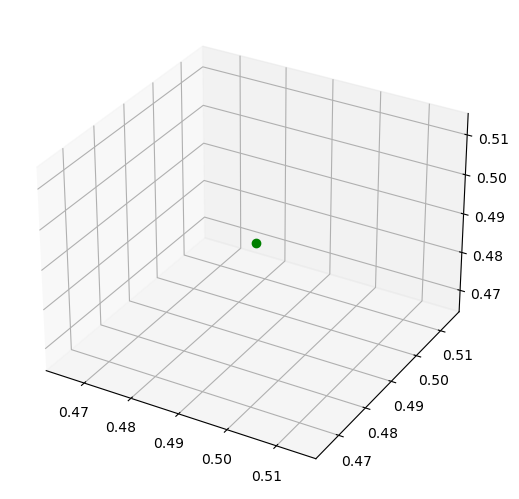

In [246]:
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
dotsEgo = ax.plot(dataSet[0][0], dataSet[1][0], dataSet[2][0], 'go')[0] # For scatter plot
x=np.linspace(0, 45, numDataPoints)